<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-06-14 19:14:13--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-06-14 19:14:13 (198 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [6]:
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dtype: object

# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [8]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

In [9]:
import seaborn as sns


In [10]:
# !pip3 install matplotlib==3.1.3

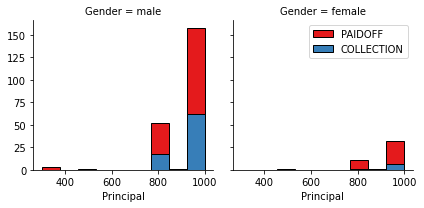

In [11]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


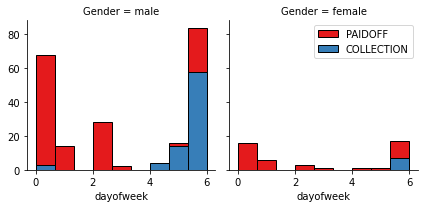

In [12]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


In [14]:
df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                    object
dayofweek                  int64
weekend                    int64
dtype: object

Let's look at gender:


In [15]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [16]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [18]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [19]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [20]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [21]:
X.shape

(346, 8)

What are our lables?


In [22]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [23]:
y.shape

(346,)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [24]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [25]:
print(df.shape)
print(X.shape)
print(y.shape)

(346, 12)
(346, 8)
(346,)


In [26]:
# !pip install scikit-learn==0.23.1

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(276, 8) (70, 8)
(276,) (70,)


In [28]:
Ks = 10
mean_acc = np.zeros((Ks-1))
print(mean_acc)
std_acc = np.zeros((Ks-1))
print(std_acc)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_knn_hat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_knn_hat)

    
    std_acc[n-1]=np.std(y_knn_hat==y_test)/np.sqrt(y_knn_hat.shape[0])

mean_acc


array([0.77142857, 0.61428571, 0.77142857, 0.65714286, 0.77142857,
       0.72857143, 0.77142857, 0.67142857, 0.71428571])

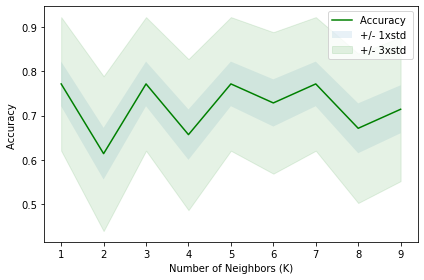

In [30]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [31]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7714285714285715 with k= 1


### Insights:-
we can see that with the value of k =1 and k =3 we are getting almost same result so we will take the value of k = 3 to build the model


In [32]:
#Train Model and Predict - K = 3 
neigh = KNeighborsClassifier(n_neighbors = 3).fit(X_train,y_train)
y_knn_hat=neigh.predict(X_test)

In [33]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_knn_hat))

Train set Accuracy:  0.8333333333333334
Test set Accuracy:  0.7714285714285715


In [34]:
#Train Model and Predict - K = 1
neigh_K_1 = KNeighborsClassifier(n_neighbors = 1).fit(X_train,y_train)
y_knn_hat_1=neigh_K_1.predict(X_test)

In [35]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh_K_1.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_knn_hat_1))

Train set Accuracy:  0.8876811594202898
Test set Accuracy:  0.7714285714285715


# Decision Tree
### Decision Tree using Grid search to find the best model

In [36]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [37]:
params = {
    'max_depth': [2,3, 4, 5],
    'min_samples_leaf': [5,10,15,20,30],
    'criterion': ["gini", "entropy"]
}

In [38]:
from sklearn.tree import DecisionTreeClassifier
tree= DecisionTreeClassifier()

# run grid search
folds = 4
grid_search_tree = GridSearchCV(estimator=DecisionTreeClassifier(), 
                               cv = folds,
                               param_grid=params, 
                               return_train_score=True,                         
                               verbose = 1)

In [39]:
# fit 
%time
grid_search_tree.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.82 µs
Fitting 4 folds for each of 40 candidates, totalling 160 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [5, 10, 15, 20, 30]},
             return_train_score=True, verbose=1)

In [40]:
grid_search_tree.best_params_

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}

In [41]:
dt_best = grid_search_tree.best_estimator_

### Prediction

In [42]:
predTree = dt_best.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'COLLECTION']


In [43]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.7285714285714285


In [44]:
# !conda install -c conda-forge pydotplus -y

In [45]:
# !conda install -c conda-forge python-graphviz -y

In [46]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

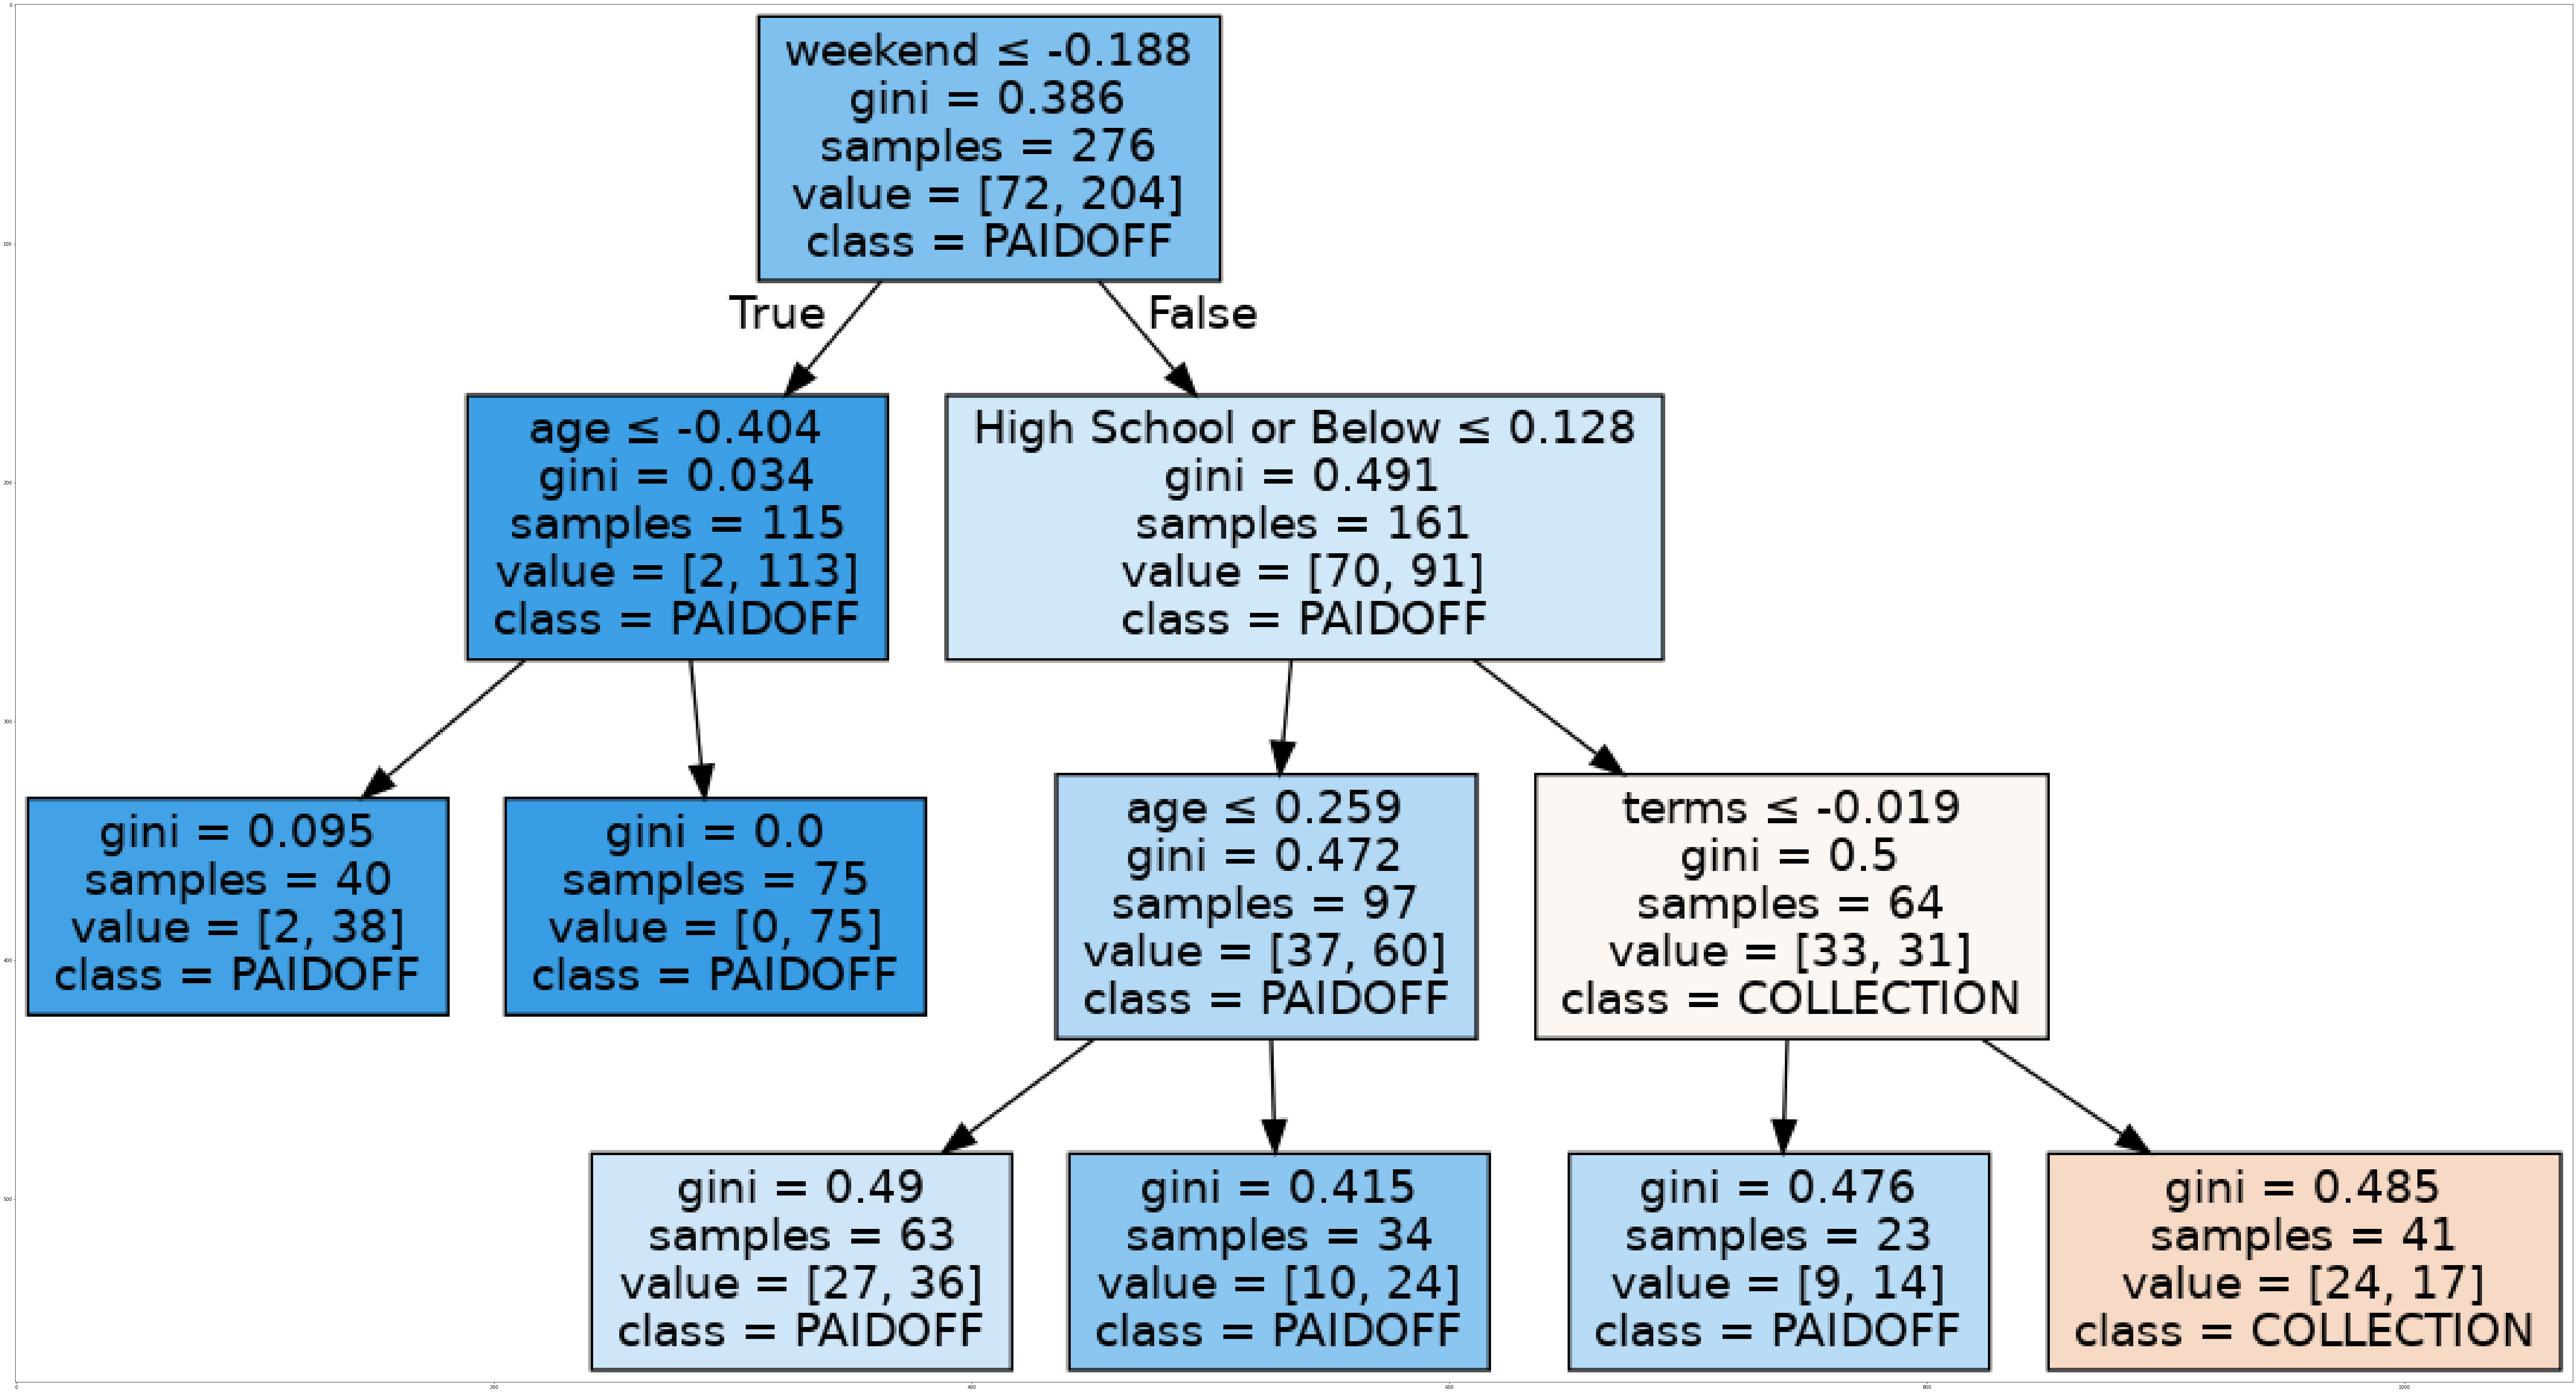

In [47]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = Feature.columns
out=tree.export_graphviz(dt_best,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine


In [48]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

In [49]:
yhat_svm = clf.predict(X_test)
yhat_svm [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.17      0.14      0.15        14
     PAIDOFF       0.79      0.82      0.81        56

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.67      0.69      0.68        70

Confusion matrix, without normalization
[[46 10]
 [12  2]]


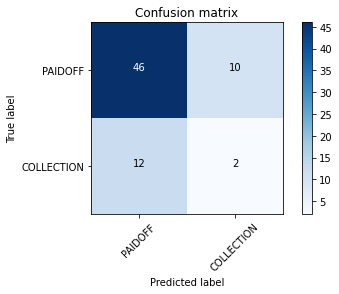

In [52]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_svm, labels=["PAIDOFF","COLLECTION"])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_svm))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [53]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat_svm, average='weighted') 

0.6763832658569502

In [54]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_svm,pos_label="PAIDOFF")

0.6764705882352942

### Linear SVM

In [55]:
# write your code here
from sklearn import svm
clf_lin = svm.SVC(kernel='linear')
clf_lin.fit(X_train, y_train) 

yhat_Svm_lin = clf_lin.predict(X_test)
yhat_Svm_lin[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

              precision    recall  f1-score   support

  COLLECTION       0.20      0.21      0.21        14
     PAIDOFF       0.80      0.79      0.79        56

    accuracy                           0.67        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.68      0.67      0.68        70

Confusion matrix, without normalization
[[44 12]
 [11  3]]


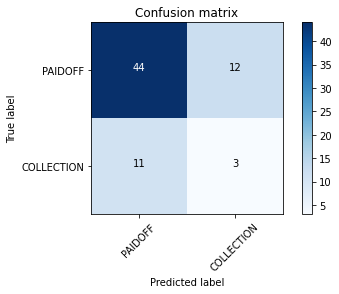

In [56]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_Svm_lin, labels=["PAIDOFF","COLLECTION"])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_Svm_lin))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [57]:
print("Avg F1-score: %.4f" %f1_score(y_test, yhat_Svm_lin, average='weighted'))
print("Jaccard score: %.4f" %jaccard_score(y_test, yhat_Svm_lin,pos_label="PAIDOFF"))

Avg F1-score: 0.6756
Jaccard score: 0.6567


### SVM_Polynomial

In [58]:
clf_poly = svm.SVC(kernel='poly')
clf_poly.fit(X_train, y_train) 

yhat_Svm_pol = clf_poly.predict(X_test)
yhat_Svm_pol[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

              precision    recall  f1-score   support

  COLLECTION       0.17      0.14      0.15        14
     PAIDOFF       0.79      0.82      0.81        56

    accuracy                           0.69        70
   macro avg       0.48      0.48      0.48        70
weighted avg       0.67      0.69      0.68        70

Confusion matrix, without normalization
[[46 10]
 [12  2]]


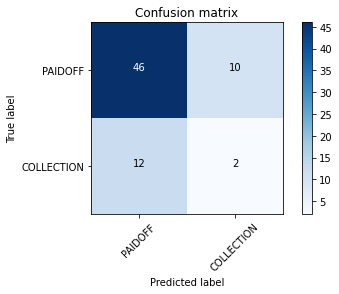

In [59]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_Svm_pol, labels=["PAIDOFF","COLLECTION"])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_Svm_pol))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [60]:
print("Avg F1-score: %.4f" %f1_score(y_test, yhat_Svm_pol, average='weighted'))
print("Jaccard score: %.4f" %jaccard_score(y_test, yhat_Svm_pol,pos_label="PAIDOFF"))

Avg F1-score: 0.6764
Jaccard score: 0.6765


### SVM_Sigmoid

In [61]:
clf_sig = svm.SVC(kernel='sigmoid')
clf_sig.fit(X_train, y_train) 

yhat_Svm_sig = clf_sig.predict(X_test)
yhat_Svm_sig[0:5]

array(['COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION'],
      dtype=object)

              precision    recall  f1-score   support

  COLLECTION       0.24      0.36      0.29        14
     PAIDOFF       0.82      0.71      0.76        56

    accuracy                           0.64        70
   macro avg       0.53      0.54      0.52        70
weighted avg       0.70      0.64      0.67        70

Confusion matrix, without normalization
[[40 16]
 [ 9  5]]


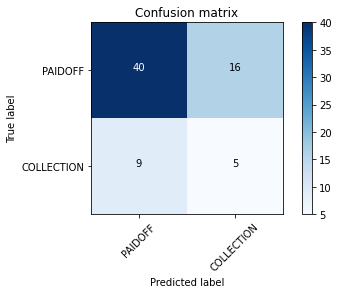

In [62]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_Svm_sig, labels=["PAIDOFF","COLLECTION"])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_Svm_sig))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [63]:
print("Avg F1-score: %.4f" %f1_score(y_test, yhat_Svm_sig, average='weighted'))
print("Jaccard score: %.4f" %jaccard_score(y_test, yhat_Svm_sig,pos_label="PAIDOFF"))

Avg F1-score: 0.6667
Jaccard score: 0.6154


# Logistic Regression


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, solver='liblinear')

In [65]:
yhat_log = LR.predict(X_test)
yhat_log

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION'], dtype=object)

In [66]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.49, 0.51],
       [0.31, 0.69],
       [0.51, 0.49],
       [0.27, 0.73],
       [0.46, 0.54],
       [0.28, 0.72],
       [0.54, 0.46],
       [0.49, 0.51],
       [0.29, 0.71],
       [0.49, 0.51],
       [0.45, 0.55],
       [0.47, 0.53],
       [0.45, 0.55],
       [0.44, 0.56],
       [0.29, 0.71],
       [0.52, 0.48],
       [0.45, 0.55],
       [0.28, 0.72],
       [0.45, 0.55],
       [0.48, 0.52],
       [0.44, 0.56],
       [0.48, 0.52],
       [0.47, 0.53],
       [0.46, 0.54],
       [0.3 , 0.7 ],
       [0.51, 0.49],
       [0.45, 0.55],
       [0.46, 0.54],
       [0.52, 0.48],
       [0.32, 0.68],
       [0.48, 0.52],
       [0.39, 0.61],
       [0.35, 0.65],
       [0.31, 0.69],
       [0.54, 0.46],
       [0.49, 0.51],
       [0.26, 0.74],
       [0.28, 0.72],
       [0.47, 0.53],
       [0.28, 0.72],
       [0.31, 0.69],
       [0.29, 0.71],
       [0.31, 0.69],
       [0.49, 0.51],
       [0.44, 0.56],
       [0.35, 0.65],
       [0.35, 0.65],
       [0.44,

In [67]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat_log,pos_label="PAIDOFF")

0.6865671641791045

              precision    recall  f1-score   support

  COLLECTION       0.23      0.21      0.22        14
     PAIDOFF       0.81      0.82      0.81        56

    accuracy                           0.70        70
   macro avg       0.52      0.52      0.52        70
weighted avg       0.69      0.70      0.70        70

Confusion matrix, without normalization
[[46 10]
 [11  3]]


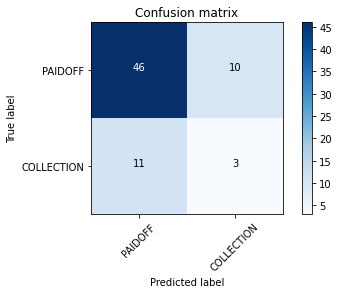

In [68]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_log, labels=["PAIDOFF","COLLECTION"])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_log))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

In [69]:
print (classification_report(y_test, yhat_log))

              precision    recall  f1-score   support

  COLLECTION       0.23      0.21      0.22        14
     PAIDOFF       0.81      0.82      0.81        56

    accuracy                           0.70        70
   macro avg       0.52      0.52      0.52        70
weighted avg       0.69      0.70      0.70        70



In [70]:
from sklearn.metrics import log_loss
print ("LogLoss: : %.2f" % log_loss(y_test, yhat_prob))

LogLoss: : 0.58


# Model Evaluation using Test set


In [71]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:


In [72]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-06-14 19:14:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-06-14 19:14:22 (106 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [73]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [74]:
test_df.shape

(54, 10)

In [75]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [76]:
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

In [77]:
# Converting male and female to 0 and 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0


In [78]:
test_df.dtypes

Unnamed: 0                 int64
Unnamed: 0.1               int64
loan_status               object
Principal                  int64
terms                      int64
effective_date    datetime64[ns]
due_date          datetime64[ns]
age                        int64
education                 object
Gender                     int64
dtype: object

In [79]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

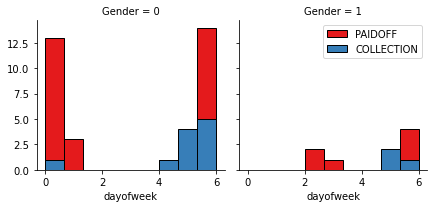

In [80]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [81]:
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [82]:
test_df.shape

(54, 12)

In [83]:
test_df[['Principal','terms','age','Gender','education']].head()


,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [84]:

#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [85]:
X = Feature_test
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [86]:
y = test_df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [87]:
print(X.shape)
print(y.shape)

(54, 8)
(54,)


In [88]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.49,  0.93,  3.06,  1.98, -1.3 ,  2.4 , -0.8 , -0.86],
       [-3.56, -1.7 ,  0.53, -0.51,  0.77, -0.42, -0.8 , -0.86],
       [ 0.49,  0.93,  1.88,  1.98,  0.77, -0.42,  1.25, -0.86],
       [ 0.49,  0.93, -0.98, -0.51,  0.77, -0.42, -0.8 ,  1.16],
       [-0.67, -0.79, -0.48, -0.51,  0.77,  2.4 , -0.8 , -0.86]])

# Prediction on Test Data Set

In [89]:
print(test_df.shape)
print(X.shape)
print(y.shape)

(54, 12)
(54, 8)
(54,)


## K Nearest Neighbor(KNN)

In [90]:
# We will be selecting the value of k = 3
y_knn_hat_test=neigh.predict(X)

In [91]:
print("Avg F1-score: %.4f" %f1_score(y, y_knn_hat_test, average='weighted'))
print("Jaccard score: %.4f" %jaccard_score(y, y_knn_hat_test,pos_label="PAIDOFF"))

Avg F1-score: 0.6203
Jaccard score: 0.6346


## Decision Tree

- From grid search cv , we found that for the decision tree , max_depth = 3 and min_samples_leaf = 20 was best parameter 


In [92]:
dt_best

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20)

In [93]:
Dtree_best = dt_best.predict(X)

In [94]:
print("Avg F1-score: %.4f" %f1_score(y, Dtree_best, average='weighted'))
print("Jaccard score: %.4f" %jaccard_score(y, Dtree_best,pos_label="PAIDOFF"))

Avg F1-score: 0.7705
Jaccard score: 0.7755


## Support Vector Machine

- We tried with all the method in svm i.e linear, polynomial,Radial basis function (RBF) and sigmoid 
- out of all this i selected `Radial basis function (RBF)` as it is giving the best f1 score as well as jacords score

In [95]:
yhat_svm = clf.predict(X)

In [96]:
print("Avg F1-score: %.4f" %f1_score(y, yhat_svm, average='weighted'))
print("Jaccard score: %.4f" %jaccard_score(y, yhat_svm,pos_label="PAIDOFF"))

Avg F1-score: 0.7288
Jaccard score: 0.7400


## Logistic Regression

In [97]:
yhat_log = LR.predict(X)

In [100]:
yhat_prob = LR.predict_proba(X)

In [101]:
print("Avg F1-score: %.4f" %f1_score(y, yhat_log, average='weighted'))
print("Jaccard score: %.4f" %jaccard_score(y, yhat_log,pos_label="PAIDOFF"))
print("log loss: %.4f" %log_loss(y_test, yhat_prob))


Avg F1-score: 0.7434
Jaccard score: 0.7600


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description |
|---|---|---|---|
| 2020-10-27 | 2.1 | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27 | 2.0 | Malika Singla | Added lab to GitLab |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
